# Spotify Track Popularity Prediction and Recommennder System
## Authors:
## Beniel Immanuel (862540105)
## Demetreous Stillman (862546927)


In [3]:
!pip install -U scikit-learn

In [4]:
# Import Libraries
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import re
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import shap

#Spotify Track Dataset

##EDA

In [ ]:
# Load latest version
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
df = pd.read_csv(f"{path}/dataset.csv", index_col=0)

In [ ]:
df

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


1 missing entry in artist, album name and track name

with artist, album name, track name and track genre being object type and the rest numeric

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

In [ ]:
df.columns

Index(['track_id', 'artists', 'album_name', 'track_name', 'popularity',
       'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')

In [ ]:
nrows, ncols = df.shape
nrows, ncols

(114000, 20)

In [ ]:
# Missing values in each row
missing_values_per_row = df.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (df.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

113999 row(s) have 0 missing values
1 row(s) have 3 missing values
Total number of rows with missing values: 1


In [ ]:
duplicated_rows = df.duplicated().sum()

if duplicated_rows == 0:
    print('There are 0 rows that are duplicated, which means each row in the DataFrame is unique.')
    print('So that we do not need to continue processing duplicate lines')
else:
    print(f'There are {duplicated_rows} rows that are duplicated so we need to drop those {duplicated_rows} rows')
    df = df.drop_duplicates()
    print(f'After drop duplicated rows, there are {df.shape[0]} rows left')

There are 450 rows that are duplicated so we need to drop those 450 rows
After drop duplicated rows, there are 113550 rows left


###Numerical columns

In [ ]:
numerical_cols = df[df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]]
numerical_cols.columns

Index(['popularity', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [ ]:
numerical_cols.columns

Index(['popularity', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [ ]:
numerical_cols.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,113550.000000,1.135500e+05,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000
mean,33.324139,2.280794e+05,0.567031,0.642090,5.309467,-8.243419,0.637860,0.084674,0.314067,0.155702,0.213611,0.474207,122.175888,3.904218
std,22.283976,1.064148e+05,0.173408,0.251052,3.560134,5.011401,0.480621,0.105761,0.331907,0.309216,0.190461,0.259204,29.972861,0.432115
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.741802e+05,0.456000,0.473000,2.000000,-9.997750,0.000000,0.035900,0.016800,0.000000,0.098000,0.260000,99.296500,4.000000
50%,35.000000,2.130000e+05,0.580000,0.685000,5.000000,-6.997000,1.000000,0.048900,0.168000,0.000041,0.132000,0.464000,122.020000,4.000000
75%,50.000000,2.615878e+05,0.695000,0.854000,8.000000,-5.001000,1.000000,0.084500,0.596000,0.048675,0.273000,0.683000,140.073750,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


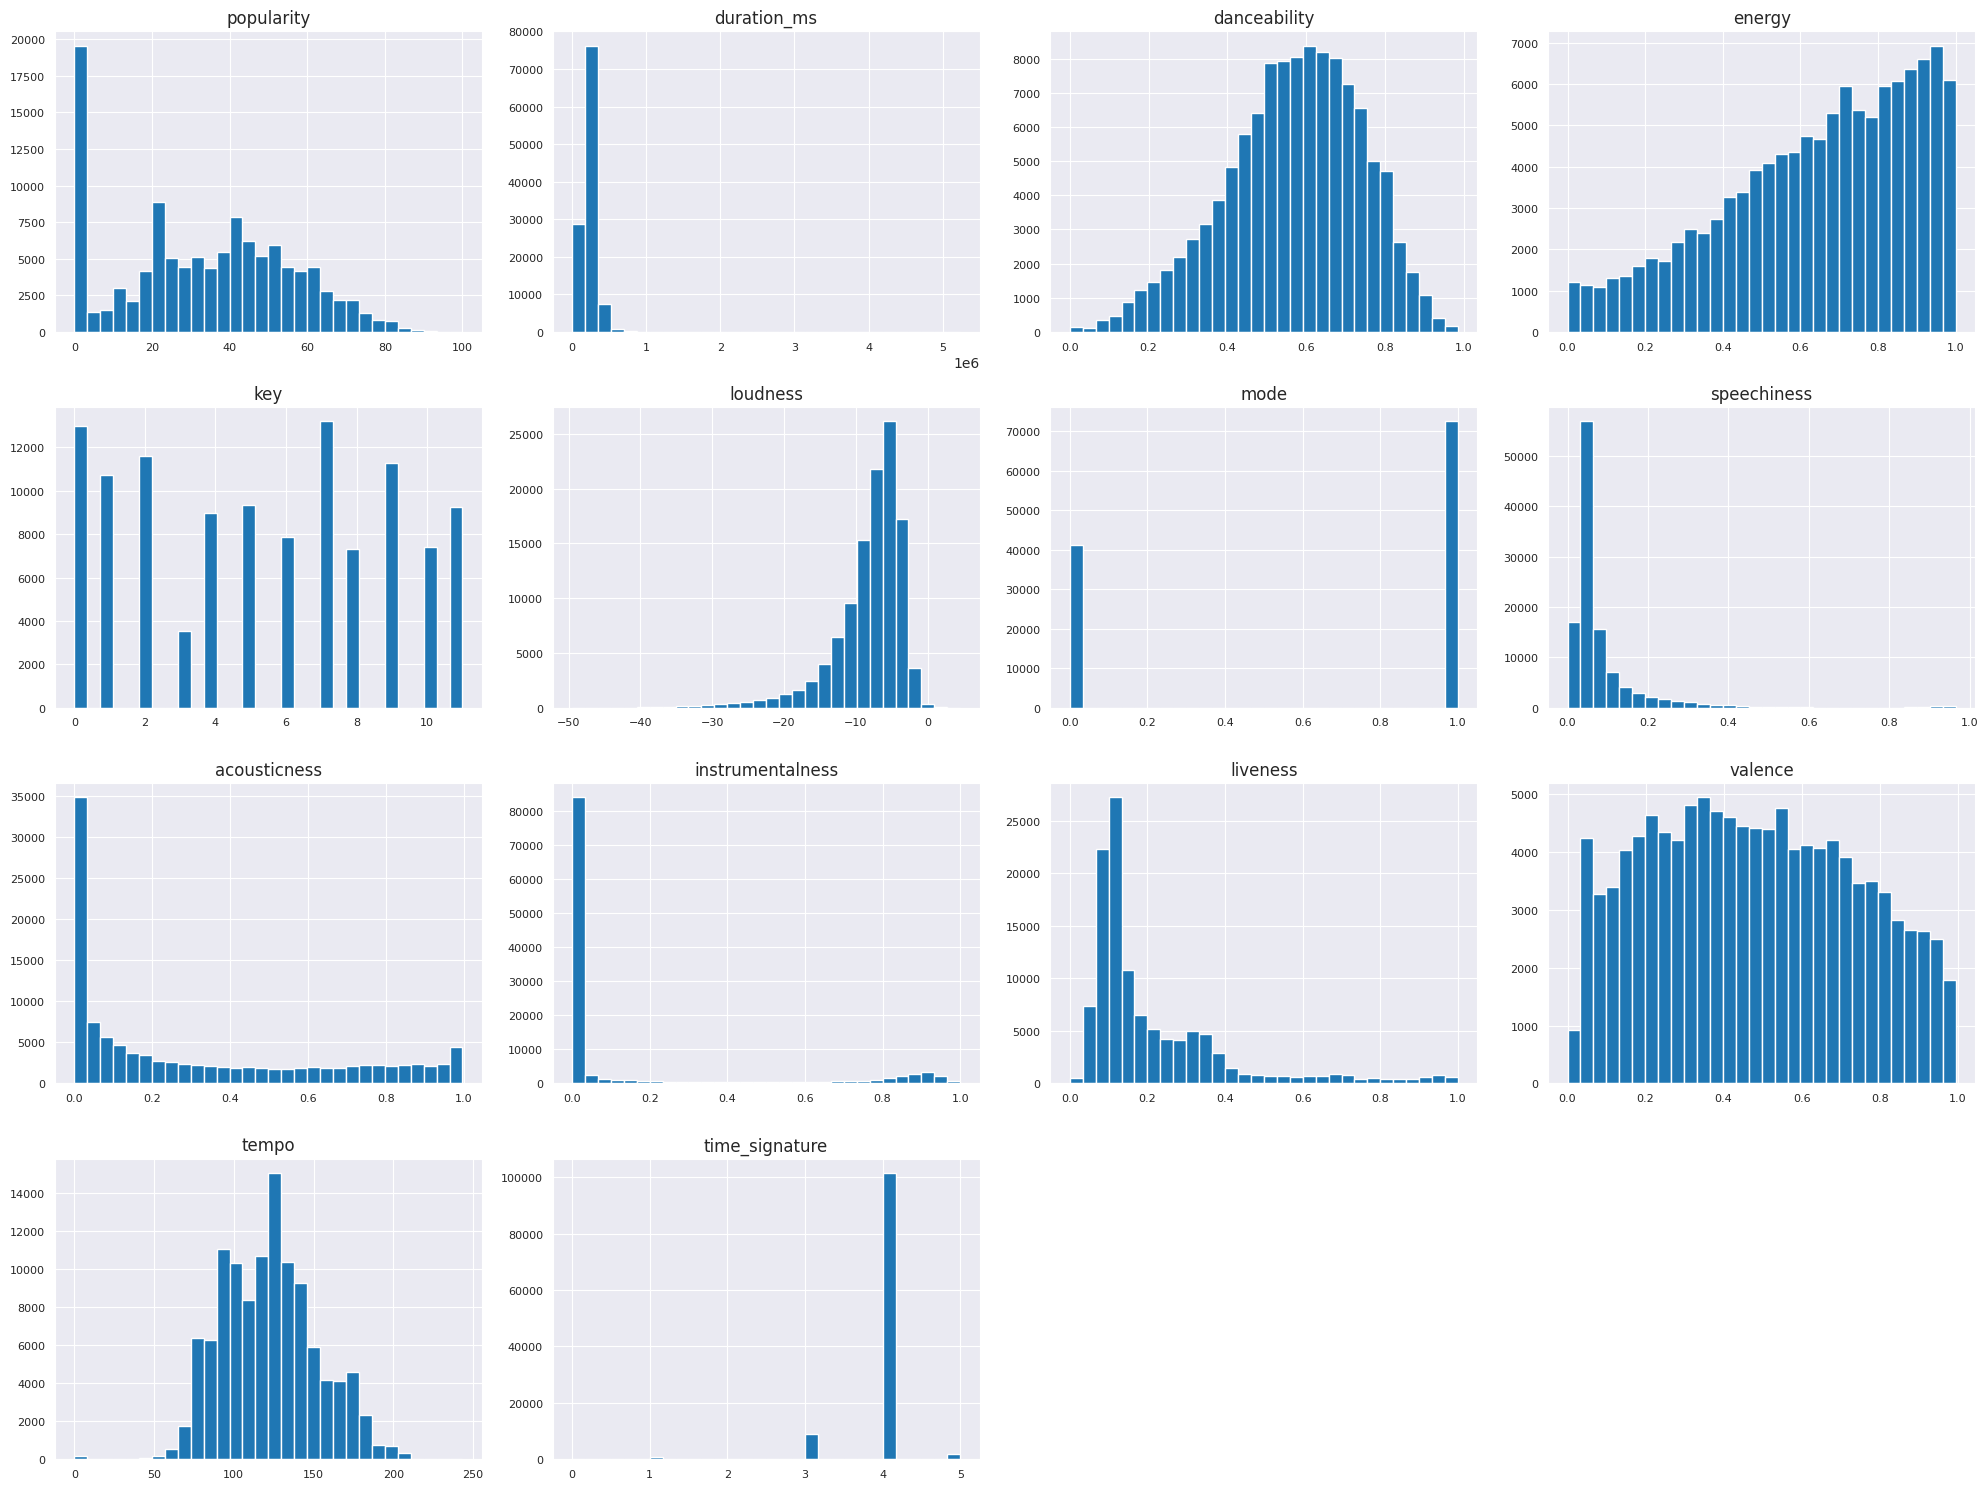

In [ ]:
sns.set_style('darkgrid')
#sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
numerical_cols.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

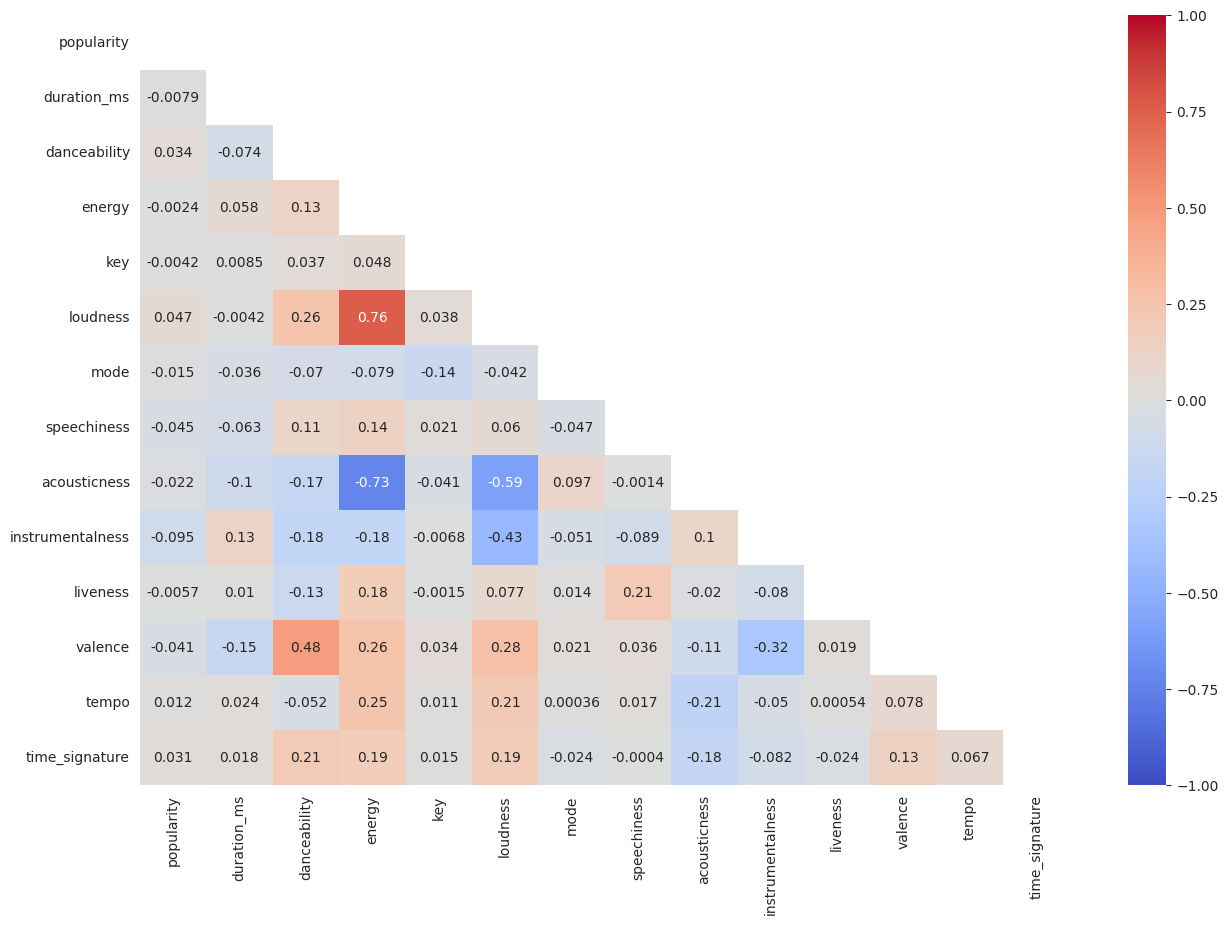

In [ ]:
# heatmap for correlation
corr = numerical_cols.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set_style('white')
#sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1,cmap='coolwarm')
plt.show()

###Categorical columns

In [ ]:
categorical_cols = df[df.columns[(df.dtypes == 'object') | (df.dtypes == 'bool')]]
categorical_cols.columns

Index(['track_id', 'artists', 'album_name', 'track_name', 'explicit',
       'track_genre'],
      dtype='object')

In [ ]:
categorical_cols.describe()

,track_id,artists,album_name,track_name,explicit,track_genre
count,113550,113549,113549,113549,113550,113550
unique,89741,31437,46589,73608,2,114
top,6S3JlDAGk3uu3NtZbPnuhS,The Beatles,Alternative Christmas 2022,Run Rudolph Run,False,acoustic
freq,9,279,195,151,103832,1000


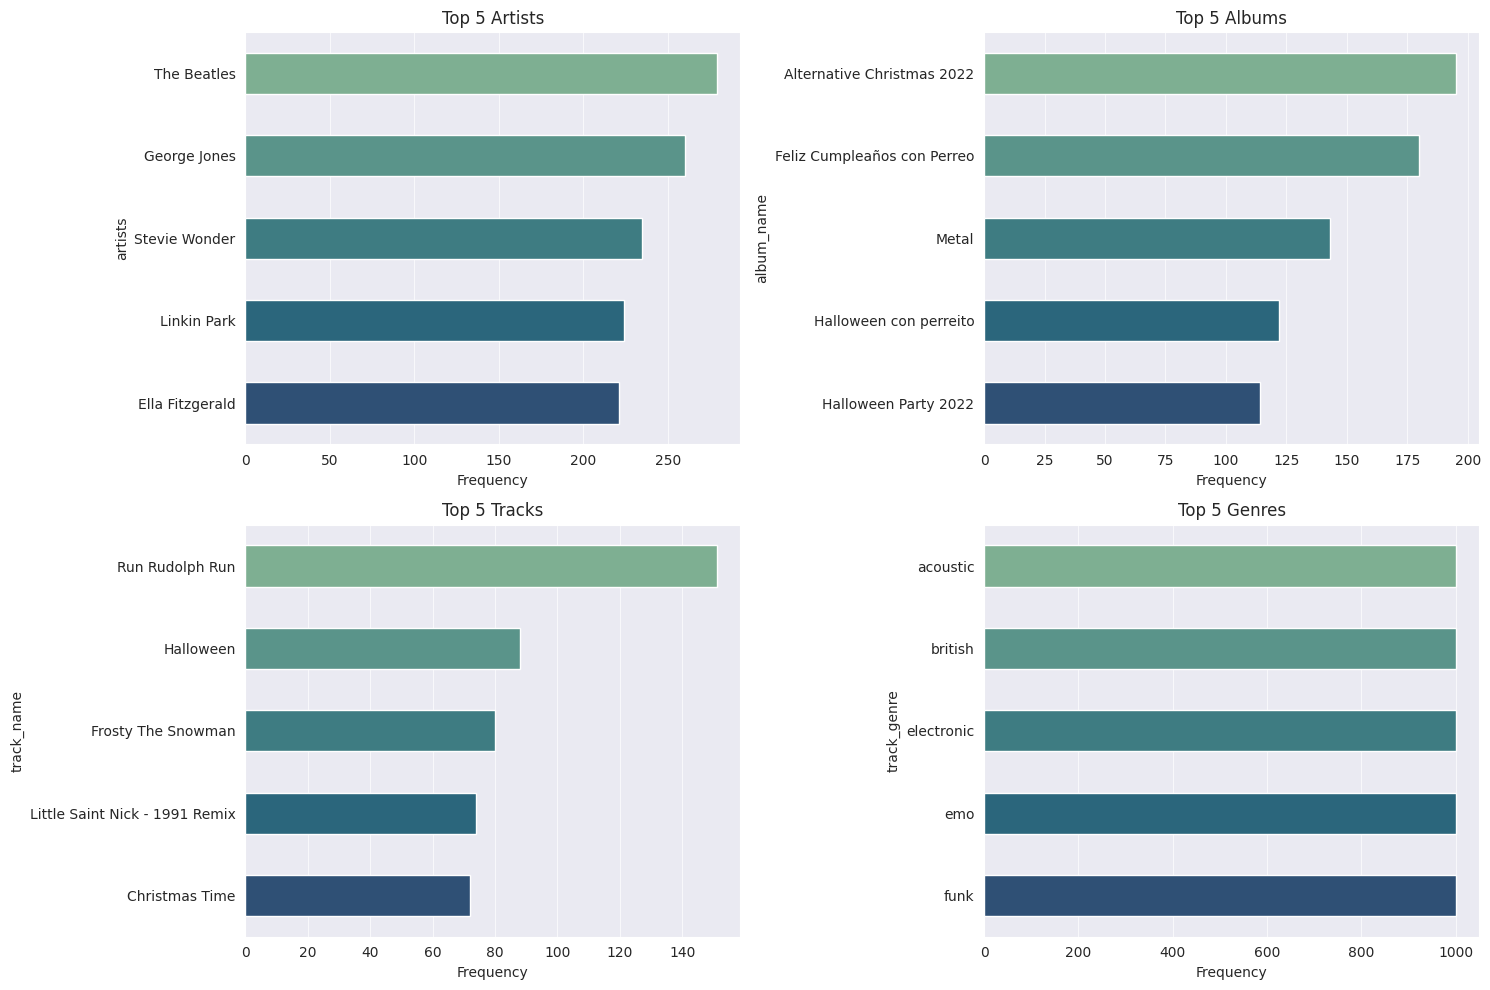

In [ ]:
top_n = 5
sns.set_style('darkgrid')
#sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
# Get the top N most frequent artists, albums, tracks, and genres
top_artists = df['artists'].value_counts().head(top_n)
top_albums = df['album_name'].value_counts().head(top_n)
top_tracks = df['track_name'].value_counts().head(top_n)
top_genres = df['track_genre'].value_counts().head(top_n)

# Disable FutureWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Plotting
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Top N Artists
    sns.barplot(x=top_artists.values, y=top_artists.index, palette="crest", ax=axes[0, 0], orient='h',  zorder=3, width=0.5)
    axes[0, 0].set_title(f'Top {top_n} Artists')
    axes[0, 0].set_xlabel('Frequency')
    axes[0, 0].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Albums
    sns.barplot(x=top_albums.values, y=top_albums.index, palette="crest", ax=axes[0, 1], orient='h', zorder=3, width=0.5)
    axes[0, 1].set_title(f'Top {top_n} Albums')
    axes[0, 1].set_xlabel('Frequency')
    axes[0, 1].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Tracks
    sns.barplot(x=top_tracks.values, y=top_tracks.index, palette="crest", ax=axes[1, 0], orient='h', zorder=3, width=0.5)
    axes[1, 0].set_title(f'Top {top_n} Tracks')
    axes[1, 0].set_xlabel('Frequency')
    axes[1, 0].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Genres
    sns.barplot(x=top_genres.values, y=top_genres.index, palette="crest", ax=axes[1, 1], orient='h', zorder=3, width=0.5)
    axes[1, 1].set_title(f'Top {top_n} Genres')
    axes[1, 1].set_xlabel('Frequency')
    axes[1, 1].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    plt.tight_layout()
    plt.show()

## Machine Learning (Popularity Regression)

In [13]:
# Load latest version
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
df = pd.read_csv(f"{path}/dataset.csv", index_col=0)

# Drop nulls
df = df.dropna(axis=0)

# One-hot encode genre
df = pd.get_dummies(df, columns=['track_genre'], prefix='genre')
genre_cols = [col for col in df.columns if col.startswith('genre_')]
df[genre_cols] = df[genre_cols].astype(int)

# Group by both artist and album to get track count
album_track_counts = (df.groupby(['artists', 'album_name'])['track_id'].count().rename('album_track_count').reset_index())
# Merge back
df = df.merge(album_track_counts, on=['artists', 'album_name'], how='left')

# New column for tracks with feature
df['contains_feature'] = df['track_name'].str.contains(r'\b(feat|ft|featuring)\b', case=False, regex=True).astype(int)

# New column for tracks with remix
df['contains_remix'] = df['track_name'].str.contains(r'\b(remix|rmx|edit)\b', case=False, regex=True).astype(int)


# ------------------- Group genres into super categories -------------------
genre_map = {
    'rock': [
        'rock', 'alt-rock', 'alternative', 'rock-n-roll', 'hard-rock',
        'psych-rock', 'grunge', 'garage', 'punk', 'punk-rock', 'emo',
        'hardcore', 'indie', 'singer-songwriter', 'rockabilly'
    ],
    'pop': [
        'pop', 'indie-pop', 'power-pop', 'synth-pop', 'pop-film', 'j-pop',
        'k-pop', 'cantopop', 'mandopop'
    ],
    'electronic': [
        'edm', 'electronic', 'electro', 'house', 'deep-house', 'techno',
        'minimal-techno', 'progressive-house', 'trance', 'club',
        'chicago-house', 'detroit-techno', 'breakbeat', 'drum-and-bass',
        'dubstep', 'idm', 'trip-hop', 'dub'
    ],
    'hiphop_rnb': ['hip-hop', 'r-n-b', 'rap'],
    'classical': ['classical', 'opera', 'piano'],
    'jazz_blues': ['jazz', 'blues', 'funk', 'soul'],
    'country_folk': ['country', 'folk', 'bluegrass', 'honky-tonk'],
    'world_latin': [
        'latin', 'latino', 'salsa', 'samba', 'brazil', 'spanish', 'reggaeton',
        'reggae', 'forro', 'pagode', 'mpb', 'world-music', 'tango', 'dancehall'
    ],
    'metal': [
        'metal', 'heavy-metal', 'black-metal', 'death-metal',
        'metalcore', 'grindcore'
    ],
    'other': [
        'ambient', 'new-age', 'study', 'sleep', 'anime', 'comedy', 'children',
        'kids', 'disney', 'show-tunes', 'romance', 'happy', 'sad', 'party',
        'dance', 'gospel', 'goth', 'groove', 'industrial',
        'songwriter', 'guitar'
    ],
    'regional': [
        'indian', 'malay', 'iranian', 'french', 'german', 'turkish', 'swedish',
        'j-dance', 'j-idol', 'j-rock'
    ]
}

for super_genre, sub_genres in genre_map.items():
    cols = [f"genre_{g}" for g in sub_genres if f"genre_{g}" in df.columns]
    if cols:  # Only create if any matching columns found
        df[f"is_{super_genre}"] = df[cols].max(axis=1)
# --------------------------------------------------------------------------

# Encode explicit column
df['explicit'] = df['explicit'].astype(bool).astype(int)

# Normalize titles and compute is_single
def normalize_title(title):
    title = title.lower()
    title = re.sub(r'[\(\)\[\]\{\}]', '', title)  # remove brackets
    title = re.sub(r'[-_]', ' ', title)           # replace dashes and underscores with space
    title = re.sub(r'\s+', ' ', title).strip()    # remove extra whitespace
    return title

df['is_single'] = (
    df.apply(lambda row: normalize_title(row['track_name']) == normalize_title(row['album_name']), axis=1)
).astype(int)

# -------------------- Add column to use historic data of popularity from the artist --------------------

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Compute artist avg popularity (TRAINING DATA ONLY)
train_exploded = train_df[['artists', 'popularity']].copy()
train_exploded['artists'] = train_exploded['artists'].str.split(';')
train_exploded = train_exploded.explode('artists')
train_exploded['artists'] = train_exploded['artists'].str.strip()

# Dictionary mapping artist to their average popularity
artist_avg_pop = train_exploded.groupby('artists')['popularity'].mean().to_dict()

# Define function to map avg popularity from training artist dictionary
global_avg_popularity = train_df['popularity'].mean()

def map_avg_popularity(row):
    artists = [a.strip() for a in row.split(';')]
    return sum(artist_avg_pop.get(a, global_avg_popularity) for a in artists) / len(artists)
    #return sum(artist_avg_pop.get(a, 0) for a in artists) / len(artists)

# Add the new column to both sets
train_df['artist_avg_popularity'] = train_df['artists'].apply(map_avg_popularity)
test_df['artist_avg_popularity'] = test_df['artists'].apply(map_avg_popularity)

# ------------------------------------------------------------------------------------------------------

# Drop non numeric columns after using them
drop_cols = ['track_id', 'artists', 'album_name', 'track_name']
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

# Drop subgenres
train_df = train_df.drop(columns=genre_cols)
test_df = test_df.drop(columns=genre_cols)

# Align test_df columns with train_df
train_df, test_df = train_df.align(test_df, join='left', axis=1)
train_df.head()


<ipython-input-13-a1cf71a990da>:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['contains_feature'] = df['track_name'].str.contains(r'\b(feat|ft|featuring)\b', case=False, regex=True).astype(int)
<ipython-input-13-a1cf71a990da>:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['contains_remix'] = df['track_name'].str.contains(r'\b(remix|rmx|edit)\b', case=False, regex=True).astype(int)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,is_hiphop_rnb,is_classical,is_jazz_blues,is_country_folk,is_world_latin,is_metal,is_other,is_regional,is_single,artist_avg_popularity
96252,41,358733,0,0.641,0.880,11,-6.401,0,0.0604,0.1510,...,0,0,0,0,1,0,0,0,0,41.722222
70416,52,231520,0,0.668,0.361,5,-9.710,0,0.0353,0.7950,...,0,0,0,0,0,0,0,0,0,52.000000
66687,11,98386,0,0.786,0.225,9,-16.516,1,0.5730,0.6790,...,0,0,0,0,0,0,1,0,0,15.095238
51391,61,232173,0,0.709,0.829,0,-5.817,1,0.2450,0.0698,...,1,0,0,0,0,0,0,0,0,61.229150
95122,37,360320,0,0.786,0.702,0,-6.742,1,0.0456,0.5110,...,0,0,0,0,1,0,0,0,0,37.000000


In [ ]:
test_df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,is_hiphop_rnb,is_classical,is_jazz_blues,is_country_folk,is_world_latin,is_metal,is_other,is_regional,is_single,artist_avg_popularity
113185,50,440247,0,0.369,0.598,7,-6.984,1,0.0304,0.00511,...,0,0,0,0,1,0,0,0,1,44.536232
42819,11,93933,0,0.171,0.997,7,-3.586,1,0.1180,0.00521,...,0,0,0,0,0,1,0,0,0,13.666667
59311,0,213578,0,0.173,0.803,9,-10.071,0,0.1440,0.61300,...,0,0,0,0,0,0,0,1,0,0.000000
90416,34,146706,0,0.419,0.382,9,-13.438,1,0.0322,0.32000,...,0,0,0,0,0,0,0,0,0,43.666667
61000,57,236293,0,0.555,0.941,9,-3.294,0,0.0481,0.48400,...,0,0,0,0,0,0,0,1,0,25.569231


In [14]:
# Test Train Split
X_train = train_df.drop(columns='popularity')
y_train = train_df['popularity']
X_test = test_df.drop(columns='popularity')
y_test = test_df['popularity']

In [86]:
# Random serach to find the best parameters for XGBRegressor

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2.0]
}

xgb_model = xgb.XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Get mean and standard deviation of test scores
mean_rmse = -random_search.best_score_
std_rmse = random_search.cv_results_['std_test_score'][random_search.best_index_]

print("Best parameters found:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)
print(f"Standard deviation of RMSE: {std_rmse:.4f}")

# For Mean popularity for nulls
# Best parameters found: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
# Best RMSE: 10.79936949412028

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found: {'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}
Best RMSE: 10.124917984008789
Standard deviation of RMSE: 0.0949


In [15]:
xgb_model = xgb.XGBRegressor(subsmaple=0.6,reg_lamda=1,reg_alpha=0.01, n_estimators=200, max_depth=12, learning_rate=0.05, gamma=0.1, colsample_bytree=1)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train, y_pred))
r2 = r2_score(y_train, y_pred)

print("Train Test RMSE:", rmse)
print("Train Test R2 Score:", r2, "\n")

y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Test RMSE:", rmse)
print("Test R2 Score:", r2)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:57:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "reg_lamda", "subsmaple" } are not used.

  warnings.warn(smsg, UserWarning)


Train Test RMSE: 5.6875590227019845
Train Test R2 Score: 0.9350230693817139 

Test RMSE: 11.55565411778337
Test R2 Score: 0.7308285236358643


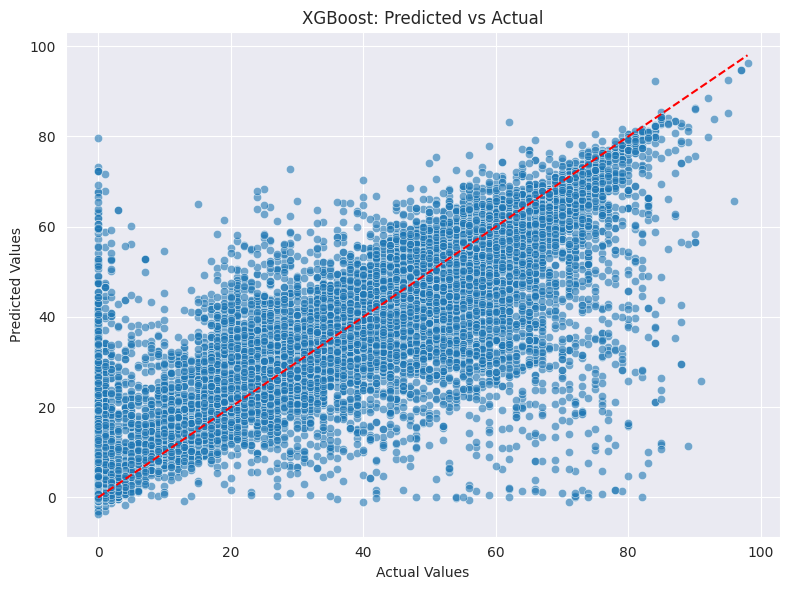

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost: Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


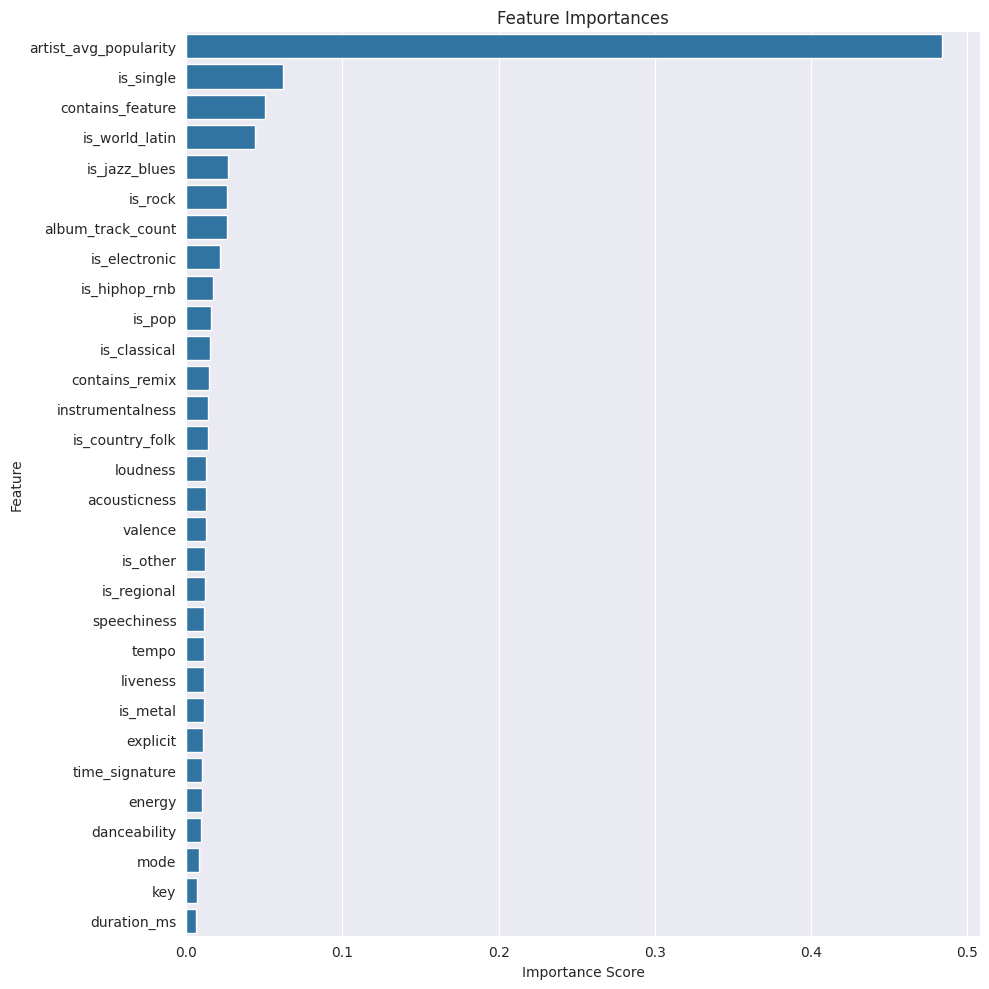

In [ ]:
importances = xgb_model.feature_importances_
features = X_train.columns

# Sort features by importance
sorted_idx = importances.argsort()[::-1]
sorted_features = [features[i] for i in sorted_idx]

plt.figure(figsize=(10, 10))
sns.barplot(x=importances[sorted_idx], y=sorted_features)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

100%|===================| 22793/22800 [25:34<00:00]       

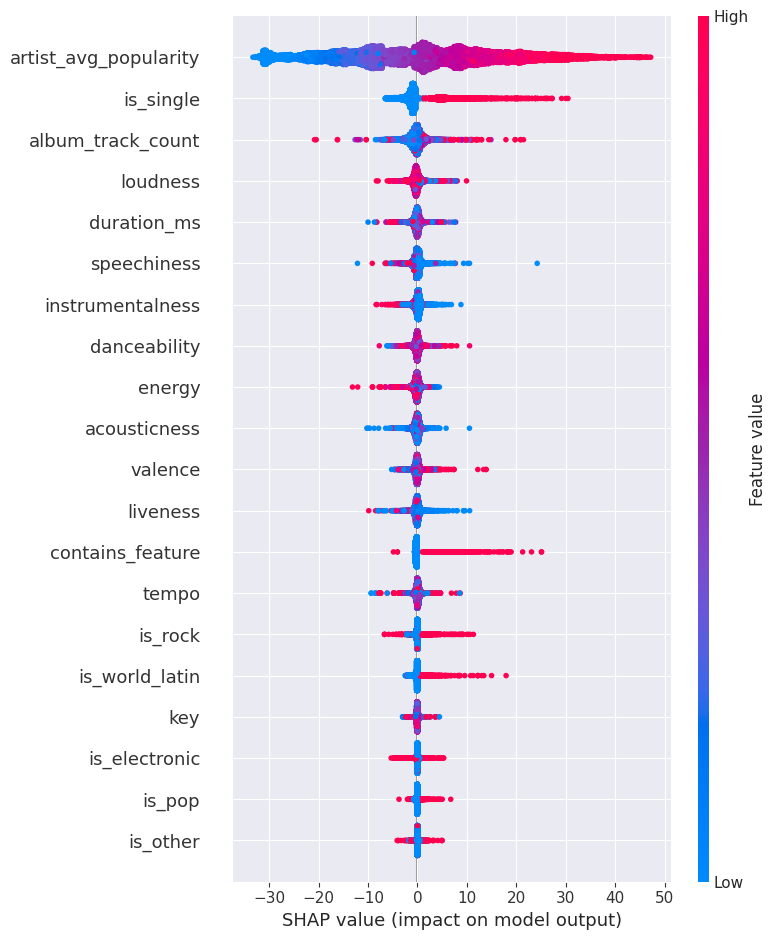

In [ ]:
# Explainer using your XGBoost regressor
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary plot
#shap.summary_plot(shap_values, X_test, plot_type="bar")
# Beeswarm: shows direction + distribution
shap.summary_plot(shap_values, X_test)


### Demo

In [81]:
# Latin Pop Artist Track

track_vector = {
    'duration_ms': 210000.0,             # ~3.5 minutes
    'explicit': 0.0,
    'danceability': 0.82,
    'energy': 0.88,
    'key': 5.0,
    'loudness': -3.0,
    'mode': 1.0,
    'speechiness': 0.04,
    'acousticness': 0.1,
    'instrumentalness': 0.00001,
    'liveness': 0.2,
    'valence': 0.75,
    'tempo': 110.0,
    'time_signature': 4.0,
    'album_track_count': 1.0,            # single
    'contains_feature': 1.0,
    'contains_remix': 1.0,
    'is_rock': 0.0,
    'is_pop': 1.0,
    'is_electronic': 0.0,
    'is_hiphop_rnb': 0.0,
    'is_classical': 0.0,
    'is_jazz_blues': 0.0,
    'is_country_folk': 0.0,
    'is_world_latin': 1.0,               # Latin pop fusion
    'is_metal': 0.0,
    'is_other': 0.0,
    'is_regional': 0.0,
    'is_single': 1.0,
    'artist_avg_popularity': 52.0,       # average artist popularity
}


# Make sure the column order matches X_train
input_df = pd.DataFrame([track_vector], columns=X_train.columns)

# Predict
pred = xgb_model.predict(input_df)
print("Predicted value:", pred[0])

Predicted value: 63.595734


In [84]:
# Experimental EDM Artist

track_vector = {
    'duration_ms': 380000.0,
    'explicit': 0.0,
    'danceability': 0.6,
    'energy': 0.4,                        # low energy
    'key': 1.0,
    'loudness': -11.5,                    # very quiet
    'mode': 0.0,
    'speechiness': 0.15,
    'acousticness': 0.45,
    'instrumentalness': 0.75,            # mostly instrumental
    'liveness': 0.5,
    'valence': 0.1,                       # low positivity
    'tempo': 70.0,                        # slow tempo
    'time_signature': 4.0,
    'album_track_count': 12.0,
    'contains_feature': 0.0,
    'contains_remix': 0.0,
    'is_rock': 0.0,
    'is_pop': 0.0,
    'is_electronic': 1.0,
    'is_hiphop_rnb': 0.0,
    'is_classical': 0.0,
    'is_jazz_blues': 0.0,
    'is_country_folk': 0.0,
    'is_world_latin': 0.0,
    'is_metal': 0.0,
    'is_other': 0.0,                      # niche/experimental
    'is_regional': 0.0,
    'is_single': 0.0,
    'artist_avg_popularity': 39.0,
}

# Make sure the column order matches X_train
input_df = pd.DataFrame([track_vector], columns=X_train.columns)

# Predict
pred = xgb_model.predict(input_df)
print("Predicted value:", pred[0])

Predicted value: 39.171635


In [85]:
# Same Experimental sound but from a more popular artist

track_vector = {
    'duration_ms': 380000.0,
    'explicit': 0.0,
    'danceability': 0.6,
    'energy': 0.4,                        # low energy
    'key': 1.0,
    'loudness': -11.5,                    # very quiet
    'mode': 0.0,
    'speechiness': 0.15,
    'acousticness': 0.45,
    'instrumentalness': 0.75,             # mostly instrumental
    'liveness': 0.5,
    'valence': 0.1,                       # low positivity
    'tempo': 70.0,                        # slow tempo
    'time_signature': 4.0,
    'album_track_count': 12.0,
    'contains_feature': 0.0,
    'contains_remix': 0.0,
    'is_rock': 0.0,
    'is_pop': 0.0,
    'is_electronic': 1.0,
    'is_hiphop_rnb': 0.0,
    'is_classical': 0.0,
    'is_jazz_blues': 0.0,
    'is_country_folk': 0.0,
    'is_world_latin': 0.0,
    'is_metal': 0.0,
    'is_other': 0.0,                      # niche/experimental
    'is_regional': 0.0,
    'is_single': 0.0,
    'artist_avg_popularity': 80.0,
}

# Make sure the column order matches X_train
input_df = pd.DataFrame([track_vector], columns=X_train.columns)

# Predict
pred = xgb_model.predict(input_df)
print("Predicted value:", pred[0])

Predicted value: 69.253456


#Spotify User Behaviour Dataset

In [ ]:
#Importing the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

In [ ]:
import kagglehub
import pandas as pd

#the dataset
path = kagglehub.dataset_download("meeraajayakumar/spotify-user-behavior-dataset")

#Excel file -> csv
df = pd.read_excel(f"{path}/Spotify_data.xlsx")
csv_path = "Spotify_data.csv"
df.to_csv(csv_path, index=False)

print(f"Excel file has been converted to CSV: {csv_path}")

Excel file has been converted to CSV: Spotify_data.csv


In [ ]:
df = pd.read_csv("/content/Spotify_data.csv")
df.head()

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free (ad-supported),Yes,Family Plan-Rs 179/month,Podcast,Melody,Night,Sadness or melancholy,leisure time,Playlists,3,Daily,Comedy,Interview,Both,Both,Ok
1,12-20,Male,More than 2 years,Computer or laptop,Free (ad-supported),Yes,Individual Plan- Rs 119/ month,Podcast,Rap,Afternoon,Social gatherings or parties,Workout session,Playlists,2,Several times a week,Comedy,Interview,Both,NaN,Satisfied
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free (ad-supported),Yes,Student Plan-Rs 59/month,Podcast,Pop,Night,Relaxation and stress relief,"Study Hours, While Traveling",Playlists,4,Once a week,Sports,Interview,NaN,Both,Satisfied
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free (ad-supported),No,NaN,Music,Melody,Night,"Relaxation and stress relief, Social gathering...","Office hours, Workout session, leisure time","recommendations, Playlists",4,Never,NaN,NaN,NaN,NaN,Ok
4,20-35,Female,1 year to 2 years,Smartphone,Free (ad-supported),No,NaN,Music,Melody,Night,Relaxation and stress relief,leisure time,"recommendations, Playlists",4,Rarely,Lifestyle and Health,Story telling,Well known individuals,Both,Ok


##EDA

We have a lot of missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          520 non-null    object
 1   Gender                       520 non-null    object
 2   spotify_usage_period         520 non-null    object
 3   spotify_listening_device     520 non-null    object
 4   spotify_subscription_plan    520 non-null    object
 5   premium_sub_willingness      520 non-null    object
 6   preffered_premium_plan       312 non-null    object
 7   preferred_listening_content  520 non-null    object
 8   fav_music_genre              520 non-null    object
 9   music_time_slot              520 non-null    object
 10  music_Influencial_mood       520 non-null    object
 11  music_lis_frequency          520 non-null    object
 12  music_expl_method            520 non-null    object
 13  music_recc_rating            520 no

In [ ]:
df.describe(include='object')

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
count,520,520,520,520,520,520,312,520,520,520,520,520,520,520,372,380,379,391,520
unique,5,3,4,15,2,2,4,2,11,3,15,35,20,5,19,4,3,3,5
top,20-35,Female,More than 2 years,Smartphone,Free (ad-supported),No,Individual Plan- Rs 119/ month,Music,Melody,Night,Relaxation and stress relief,While Traveling,recommendations,Rarely,Comedy,Story telling,Both,Shorter,Ok
freq,422,391,169,300,424,334,95,410,259,312,195,111,113,201,107,152,180,191,280


In [ ]:
df.isna().sum()

,0
Age,0
Gender,0
spotify_usage_period,0
spotify_listening_device,0
spotify_subscription_plan,0
premium_sub_willingness,0
preffered_premium_plan,208
preferred_listening_content,0
fav_music_genre,0
music_time_slot,0


We havea lot of null columns. Nearly half of preferred premium plan is null so we will be removing them. The rest of the null values will be imputed with most frequent item.

In [ ]:
#drop column with all nulls
df = df.drop(columns=['preffered_premium_plan'])

#fill others with uknown
for col in ['fav_pod_genre', 'preffered_pod_format', 'pod_host_preference', 'preffered_pod_duration']:
    df[col] = df[col].fillna('Unknown')

In [ ]:
df.isna().sum()

,0
Age,0
Gender,0
spotify_usage_period,0
spotify_listening_device,0
spotify_subscription_plan,0
premium_sub_willingness,0
preferred_listening_content,0
fav_music_genre,0
music_time_slot,0
music_Influencial_mood,0


In [ ]:
df['premium_sub_willingness'].value_counts() #quite imbalanaced


,count
premium_sub_willingness,
No,334
Yes,186


Trying to visualize how our data is distributed: From Meera Jeyakumar notebook

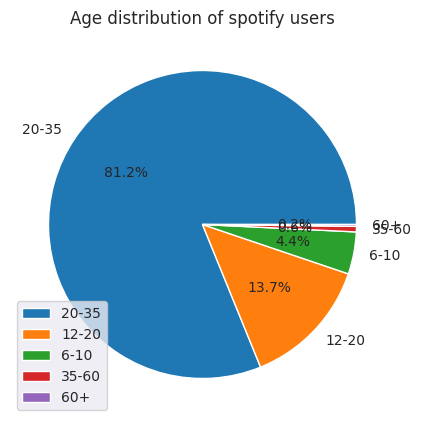

In [ ]:
#Age group
y=df['Age'].value_counts()
plt.figure(figsize=(5,5))
labels=['20-35','12-20','6-10','35-60','60+']
plt.pie(y,labels=labels,autopct='%1.1f%%')
plt.legend(loc='lower left')
plt.title('Age distribution of spotify users')
plt.show()

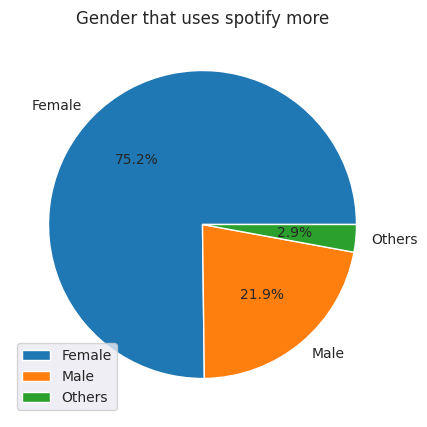

In [ ]:
#Gender
y=df['Gender'].value_counts()
plt.figure(figsize=(5,5))
labels=['Female','Male','Others']
plt.pie(y,labels=labels,autopct='%1.1f%%')
plt.legend(loc='lower left')
plt.title('Gender that uses spotify more')
plt.show()


<Axes: xlabel='spotify_subscription_plan', ylabel='count'>

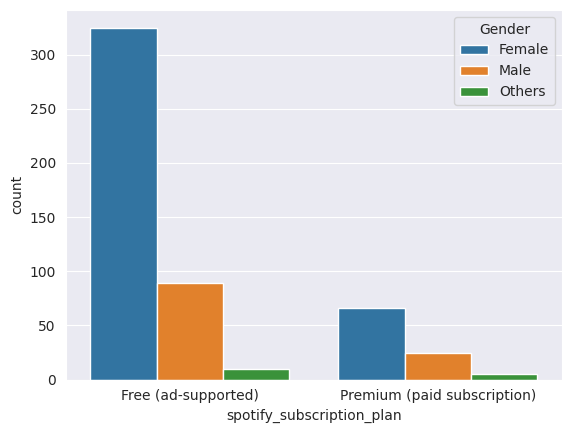

In [ ]:
#spotify subscription plan
sns.countplot(x='spotify_subscription_plan',data=df,hue='Gender')

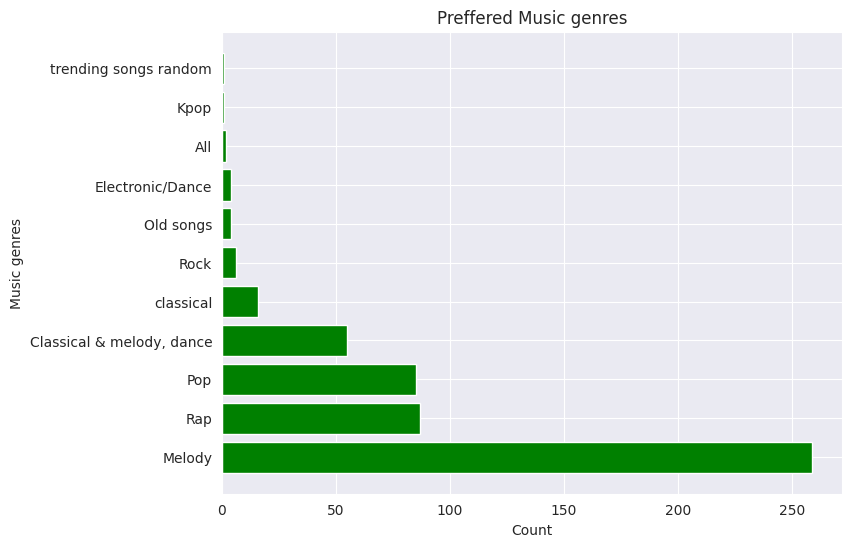

In [ ]:
#fav genre
fig,ax=plt.subplots(figsize=(8,6))
y2=df['fav_music_genre'].value_counts().values
x2=df['fav_music_genre'].unique()
plt.barh(x2,y2,color='g')
plt.xlabel('Count')
plt.ylabel('Music genres')
plt.title('Preffered Music genres')
plt.show()

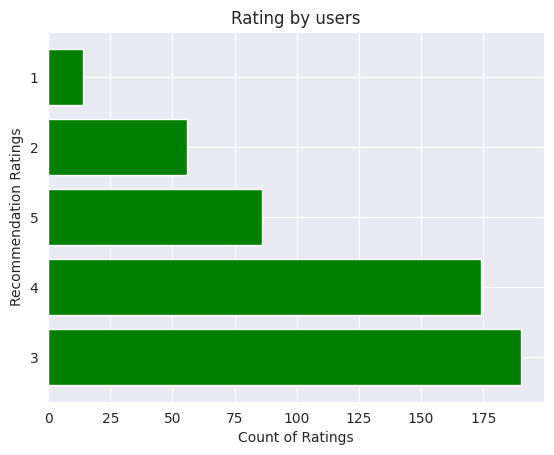

In [ ]:
#music recommendation rating
y4=df['music_recc_rating'].value_counts().values
x4=['3','4','5','2','1']
plt.barh(x4,y4,color='g')
plt.xlabel('Count of Ratings')
plt.ylabel('Recommendation Ratings')
plt.title('Rating by users')
plt.show()

In [ ]:
le=LabelEncoder()
lst=['Age','Gender','spotify_usage_period','spotify_listening_device','spotify_subscription_plan','premium_sub_willingness','preferred_listening_content','fav_music_genre','music_time_slot','music_Influencial_mood','music_lis_frequency','music_expl_method','pod_lis_frequency','fav_pod_genre','preffered_pod_format','pod_host_preference','preffered_pod_duration','pod_variety_satisfaction']
for i in lst:
  df[i]=le.fit_transform(df[i])

<Axes: >

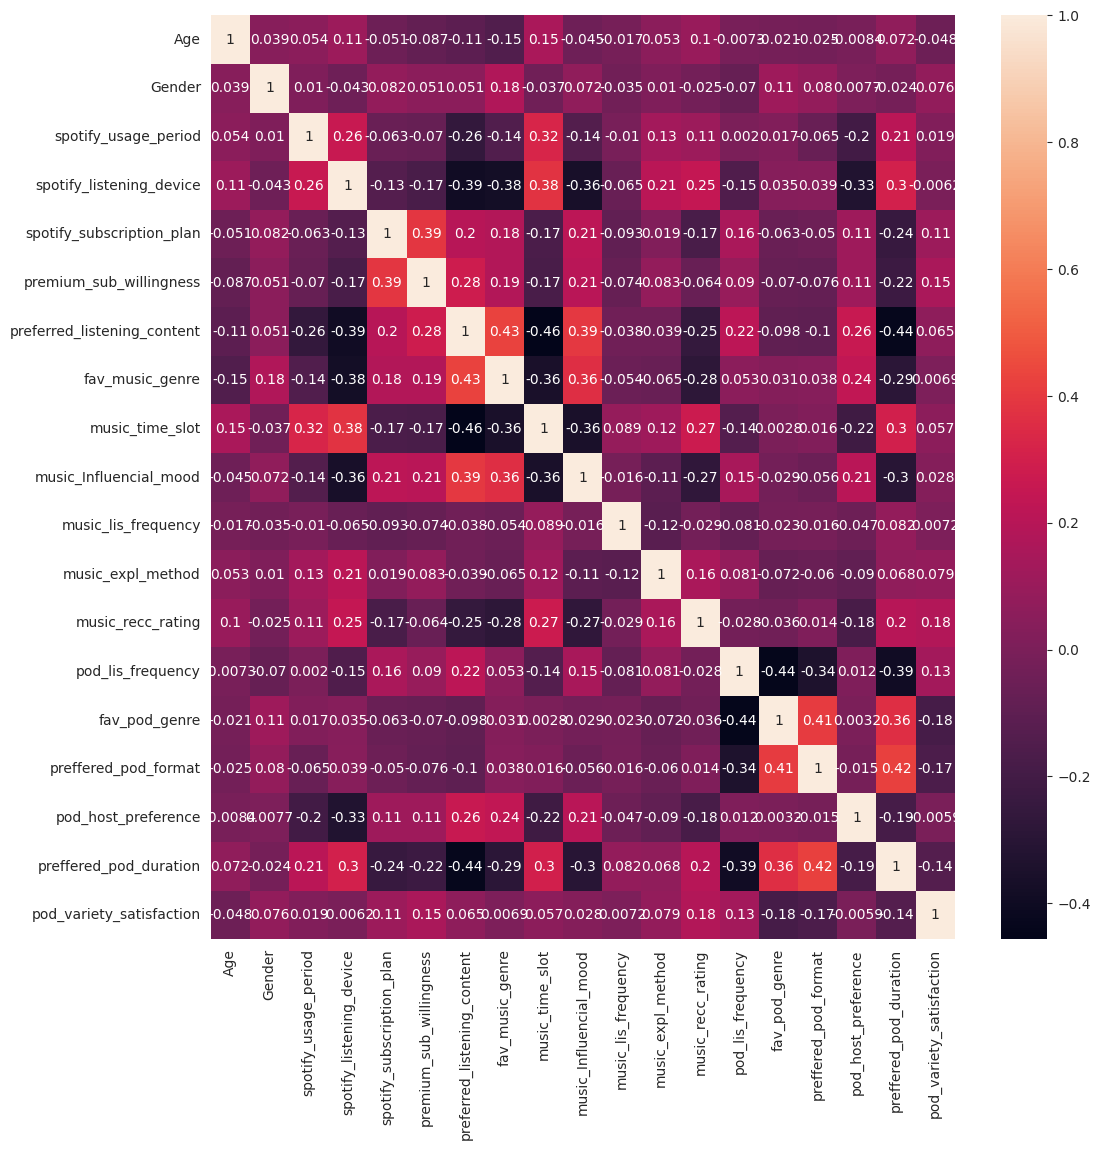

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,12))
sns.heatmap(df.corr(),annot=True)

##User behaviour System

In [ ]:
df.columns

Index(['Age', 'Gender', 'spotify_usage_period', 'spotify_listening_device',
       'spotify_subscription_plan', 'premium_sub_willingness',
       'preferred_listening_content', 'fav_music_genre', 'music_time_slot',
       'music_Influencial_mood', 'music_lis_frequency', 'music_expl_method',
       'music_recc_rating', 'pod_lis_frequency', 'fav_pod_genre',
       'preffered_pod_format', 'pod_host_preference', 'preffered_pod_duration',
       'pod_variety_satisfaction'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Age                          520 non-null    int64
 1   Gender                       520 non-null    int64
 2   spotify_usage_period         520 non-null    int64
 3   spotify_listening_device     520 non-null    int64
 4   spotify_subscription_plan    520 non-null    int64
 5   premium_sub_willingness      520 non-null    int64
 6   preferred_listening_content  520 non-null    int64
 7   fav_music_genre              520 non-null    int64
 8   music_time_slot              520 non-null    int64
 9   music_Influencial_mood       520 non-null    int64
 10  music_lis_frequency          520 non-null    int64
 11  music_expl_method            520 non-null    int64
 12  music_recc_rating            520 non-null    int64
 13  pod_lis_frequency            520 non-null    int64

In [ ]:
df.describe()

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.00000,520.000000,520.000000
mean,0.925000,0.276923,1.553846,5.609615,0.184615,0.357692,0.211538,5.398077,1.375000,4.309615,24.798077,8.109615,3.503846,2.359615,10.825000,2.332692,1.20000,1.638462,1.588462
std,0.464698,0.508356,1.200909,2.791313,0.388359,0.479782,0.408793,2.094399,0.828066,4.326099,9.416277,4.552150,0.979552,1.124051,6.688943,1.471269,1.08697,1.085933,0.955595
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,22.000000,4.000000,3.000000,1.000000,6.000000,1.000000,0.00000,1.000000,1.000000
50%,1.000000,0.000000,1.500000,6.000000,0.000000,0.000000,0.000000,4.000000,2.000000,4.000000,26.000000,9.000000,3.500000,3.000000,10.000000,3.000000,1.00000,2.000000,1.000000
75%,1.000000,0.000000,3.000000,6.000000,0.000000,1.000000,0.000000,7.000000,2.000000,8.000000,31.000000,12.250000,4.000000,3.000000,19.000000,4.000000,2.00000,2.000000,2.000000
max,4.000000,2.000000,3.000000,14.000000,1.000000,1.000000,1.000000,10.000000,2.000000,14.000000,34.000000,19.000000,5.000000,4.000000,19.000000,4.000000,3.00000,3.000000,4.000000


###Predict Premium Subscription Willingness

In [ ]:
df['fav_music_genre'].value_counts()

,count
fav_music_genre,
4,259
9,87
6,85
7,55
2,16
0,6
8,4
3,4
1,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Age                          520 non-null    int64
 1   Gender                       520 non-null    int64
 2   spotify_usage_period         520 non-null    int64
 3   spotify_listening_device     520 non-null    int64
 4   spotify_subscription_plan    520 non-null    int64
 5   premium_sub_willingness      520 non-null    int64
 6   preferred_listening_content  520 non-null    int64
 7   fav_music_genre              520 non-null    int64
 8   music_time_slot              520 non-null    int64
 9   music_Influencial_mood       520 non-null    int64
 10  music_lis_frequency          520 non-null    int64
 11  music_expl_method            520 non-null    int64
 12  music_recc_rating            520 non-null    int64
 13  pod_lis_frequency            520 non-null    int64

In [ ]:
#train test Split
X_train = df.drop(columns='premium_sub_willingness')
y_train = df['premium_sub_willingness']
X_test = df.drop(columns='premium_sub_willingness')
y_test = df['premium_sub_willingness']

In [ ]:
#hyperparameter tuning
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2.0]
}

xgb_model = xgb.XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters found:", random_search.best_params_)
print("Best RMSE from CV:", -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 1.0}
Best RMSE from CV: 0.4086963136990865


In [ ]:
#train model -> for best params
from sklearn.metrics import mean_squared_error, r2_score
best_params = random_search.best_params_
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

#metrics
y_train_pred = xgb_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
print("Train RMSE:", train_rmse)
print("Train R2 Score:", train_r2)

Train RMSE: 0.3240010093390673
Train R2 Score: 0.54308021068573


In [ ]:
#test Metrics
y_pred = xgb_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
print("Test RMSE:", test_rmse)
print("Test R2 Score:", test_r2)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred_probs = xgb_model.predict(X_test)
y_pred_class = (y_pred_probs >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("Precision:", precision_score(y_test, y_pred_class))
print("Recall:", recall_score(y_test, y_pred_class))
print("F1 Score:", f1_score(y_test, y_pred_class))

Test RMSE: 0.3240010093390673
Test R2 Score: 0.54308021068573
Accuracy: 0.8557692307692307
Precision: 0.8992805755395683
Recall: 0.6720430107526881
F1 Score: 0.7692307692307693


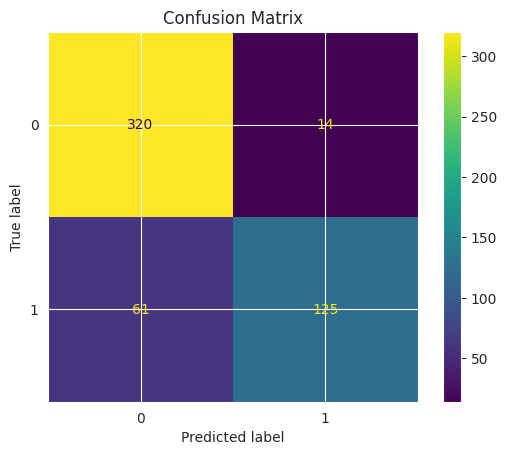

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

###User Segmentation (Clustering)

In [ ]:
features_for_clustering = [
    'Age', 'Gender', 'spotify_usage_period', 'spotify_listening_device',
    'spotify_subscription_plan', 'preferred_listening_content',
    'fav_music_genre', 'music_time_slot', 'music_Influencial_mood',
    'music_lis_frequency', 'music_expl_method', 'music_recc_rating',
    'pod_lis_frequency', 'fav_pod_genre', 'preffered_pod_format',
    'pod_host_preference', 'preffered_pod_duration', 'pod_variety_satisfaction'
]

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("/content/Spotify_data.csv")
df = df.dropna(subset=features_for_clustering).copy()

#encode categorical features
le = LabelEncoder()
for col in features_for_clustering:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col].astype(str))

#scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_for_clustering])

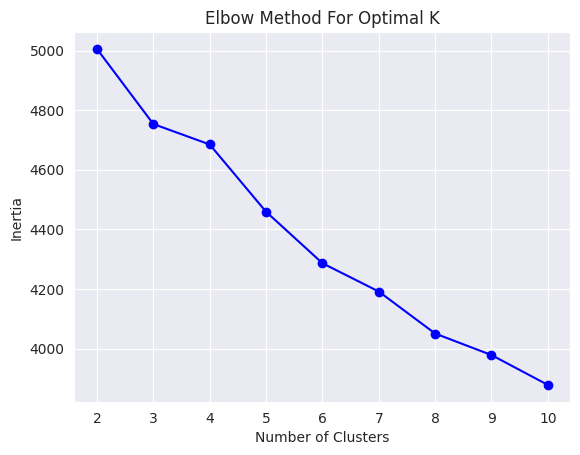

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = [] #optimal k doesnt exist :/
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

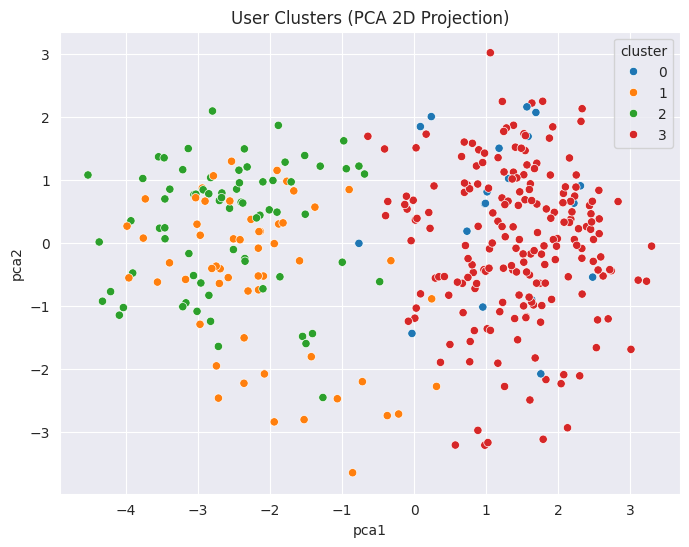

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled) #cluster plot

df['pca1'] = pca_components[:, 0]
df['pca2'] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title("User Clusters (PCA 2D Projection)")
plt.show()


Cluster 0: Young users who mostly listen to pop music on mobile and explore via recommendations.

Cluster 1: Podcast-heavy users with longer listening times.

Cluster 2: Occasional listeners, rarely explore music.

Cluster 3: Power users with premium plans and high music engagement.

In [ ]:
import pandas as pd
import numpy as np # For np.nan
#code snippet from Collab notebooks
try:
    df_original = pd.read_csv("/content/Spotify_data.csv")
except FileNotFoundError:
    print("Error: Original CSV file not found. Please check the path.")
    # Exit or handle error appropriately if you want to stop execution
    exit()

# This ensures the rows align for adding the cluster labels.
df_original_cleaned = df_original.dropna(subset=features_for_clustering).copy()

# will have the same number of rows and in the same order due to identical dropna.
if len(df_original_cleaned) == len(df):
    df_original_cleaned['cluster'] = df['cluster'].values
else:
    print(f"Warning: Row count mismatch between original cleaned data ({len(df_original_cleaned)}) and clustered data ({len(df)}).")
    print("Cluster labels may not align correctly. Proceed with caution or debug the discrepancy.")
    if 'cluster' in df.columns: # Check if cluster column exists in df
        df_original_cleaned = df_original_cleaned.assign(cluster=df['cluster'])
        if df_original_cleaned['cluster'].isnull().any():
            print("Cluster assignment resulted in NaNs. Indices might not have aligned.")

original_numerical_features = []
original_categorical_features = []

In [ ]:
for col in features_for_clustering:
    if col in df_original_cleaned.columns: # Check if column exists
        if pd.api.types.is_numeric_dtype(df_original_cleaned[col]):
            original_numerical_features.append(col)
        else: # Assumes non-numeric types (object, string, bool) are categorical
            original_categorical_features.append(col)
    else:
        print(f"Warning: Feature '{col}' not found in df_original_cleaned.")


if original_numerical_features:
    print("\n---- Numerical Features (Mean per Cluster - using original data) ----")
    numerical_profile_orig_mean = df_original_cleaned.groupby('cluster')[original_numerical_features].mean()
    print(numerical_profile_orig_mean)

    print("\n---- Numerical Features (Median per Cluster - using original data) ----")
    numerical_profile_orig_median = df_original_cleaned.groupby('cluster')[original_numerical_features].median()
    print(numerical_profile_orig_median)
else:
    print("\nNo numerical features identified for profiling from features_for_clustering in the original data.")


if original_categorical_features:
    print("\n---- Categorical Features (Mode of Original String Values per Cluster) ----")
    def get_mode_orig(series):
        mode_val = series.mode()
        return mode_val.iloc[0] if not mode_val.empty else np.nan

    categorical_profile_orig_mode = df_original_cleaned.groupby('cluster')[original_categorical_features].apply(get_mode_orig)
    print(categorical_profile_orig_mode)

    for col in original_categorical_features:
        print(f"\n---- Distribution of '{col}' by Cluster (Percentages) ----")
        try:
            distribution_table = df_original_cleaned.groupby('cluster')[col].value_counts(normalize=True).mul(100).round(1)
            print(distribution_table.astype(str) + '%')
        except Exception as e:
            print(f"Could not generate distribution for '{col}'. Error: {e}")
else:
    print("\nNo categorical features identified for profiling from features_for_clustering in the original data.")



--- METHOD 2: Profiling with Original Categorical Values (Highly Recommended) ---

---- Numerical Features (Mean per Cluster - using original data) ----
         music_recc_rating
cluster                   
0                 3.842105
1                 2.892857
2                 2.802817
3                 3.808081

---- Numerical Features (Median per Cluster - using original data) ----
         music_recc_rating
cluster                   
0                      4.0
1                      3.0
2                      3.0
3                      4.0

---- Categorical Features (Mode of Original String Values per Cluster) ----
0          Age  Gender spotify_usage_period spotify_listening_device  \
cluster                                                                
0        20-35  Female    1 year to 2 years               Smartphone   
1        20-35  Female   6 months to 1 year       Computer or laptop   
2        20-35  Female   6 months to 1 year       Computer or laptop   
3        20

# Recommender System

In [5]:
# Load latest version
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
df = pd.read_csv(f"{path}/dataset.csv", index_col=0)

# Drop nulls
df = df.dropna(axis=0)

# One-hot encode genre
df = pd.get_dummies(df, columns=['track_genre'], prefix='genre')
genre_cols = [col for col in df.columns if col.startswith('genre_')]
df[genre_cols] = df[genre_cols].astype(int)

# Group by artist and album to get track count
album_track_counts = df.groupby(['artists', 'album_name'])['track_id'].count().rename('album_track_count').reset_index()
df = df.merge(album_track_counts, on=['artists', 'album_name'], how='left')

# Feature engineering for title
df['contains_feature'] = df['track_name'].str.contains(r'\b(feat|ft|featuring)\b', case=False, regex=True).astype(int)
df['contains_remix'] = df['track_name'].str.contains(r'\b(remix|rmx|edit)\b', case=False, regex=True).astype(int)

# Group genres into super-categories
genre_map = {
    'rock': [
        'rock', 'alt-rock', 'alternative', 'rock-n-roll', 'hard-rock',
        'psych-rock', 'grunge', 'garage', 'punk', 'punk-rock', 'emo',
        'hardcore', 'indie', 'singer-songwriter', 'rockabilly'
    ],
    'pop': [
        'pop', 'indie-pop', 'power-pop', 'synth-pop', 'pop-film', 'j-pop',
        'k-pop', 'cantopop', 'mandopop'
    ],
    'electronic': [
        'edm', 'electronic', 'electro', 'house', 'deep-house', 'techno',
        'minimal-techno', 'progressive-house', 'trance', 'club',
        'chicago-house', 'detroit-techno', 'breakbeat', 'drum-and-bass',
        'dubstep', 'idm', 'trip-hop', 'dub'
    ],
    'hiphop_rnb': ['hip-hop', 'r-n-b', 'rap'],
    'classical': ['classical', 'opera', 'piano'],
    'jazz_blues': ['jazz', 'blues', 'funk', 'soul'],
    'country_folk': ['country', 'folk', 'bluegrass', 'honky-tonk'],
    'world_latin': [
        'latin', 'latino', 'salsa', 'samba', 'brazil', 'spanish', 'reggaeton',
        'reggae', 'forro', 'pagode', 'mpb', 'world-music', 'tango', 'dancehall'
    ],
    'metal': [
        'metal', 'heavy-metal', 'black-metal', 'death-metal',
        'metalcore', 'grindcore'
    ],
    'other': [
        'ambient', 'new-age', 'study', 'sleep', 'anime', 'comedy', 'children',
        'kids', 'disney', 'show-tunes', 'romance', 'happy', 'sad', 'party',
        'dance', 'gospel', 'goth', 'groove', 'industrial',
        'songwriter', 'guitar'
    ],
    'regional': [
        'indian', 'malay', 'iranian', 'french', 'german', 'turkish', 'swedish',
        'j-dance', 'j-idol', 'j-rock'
    ]
}

for super_genre, sub_genres in genre_map.items():
    cols = [f"genre_{g}" for g in sub_genres if f"genre_{g}" in df.columns]
    if cols:
        df[f"is_{super_genre}"] = df[cols].max(axis=1)

# Encode explicit
df['explicit'] = df['explicit'].astype(bool).astype(int)

# Normalize titles and compute is_single
def normalize_title(title):
    title = title.lower()
    title = re.sub(r'[\(\)\[\]\{\}]', '', title)
    title = re.sub(r'[-_]', ' ', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

df['is_single'] = (df.apply(lambda row: normalize_title(row['track_name']) == normalize_title(row['album_name']), axis=1)).astype(int)

# Compute artist average popularity
exploded = df[['artists', 'popularity']].copy()
exploded['artists'] = exploded['artists'].str.split(';')
exploded = exploded.explode('artists')
exploded['artists'] = exploded['artists'].str.strip()

artist_avg_pop = exploded.groupby('artists')['popularity'].mean().to_dict()
global_avg_popularity = df['popularity'].mean()

def map_avg_popularity(row):
    artists = [a.strip() for a in row.split(';')]
    return sum(artist_avg_pop.get(a, global_avg_popularity) for a in artists) / len(artists)

df['artist_avg_popularity'] = df['artists'].apply(map_avg_popularity)

df = df.drop_duplicates(subset=['track_name', 'artists', 'duration_ms']).reset_index(drop=True)

# Drop unused columns
#drop_cols = ['track_id', 'artists', 'album_name', 'track_name']
drop_cols = ['track_id']
df = df.drop(columns=drop_cols + genre_cols)

# Final processed dataframe ready for recommendation models
df.head()

<ipython-input-5-348ab42ca463>:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['contains_feature'] = df['track_name'].str.contains(r'\b(feat|ft|featuring)\b', case=False, regex=True).astype(int)
<ipython-input-5-348ab42ca463>:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['contains_remix'] = df['track_name'].str.contains(r'\b(remix|rmx|edit)\b', case=False, regex=True).astype(int)


,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,...,is_hiphop_rnb,is_classical,is_jazz_blues,is_country_folk,is_world_latin,is_metal,is_other,is_regional,is_single,artist_avg_popularity
0,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,-6.746,...,0,0,0,0,0,0,0,0,1,58.000000
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,...,0,0,0,0,0,0,0,0,1,42.923077
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,...,0,0,0,0,0,0,0,0,1,57.875000
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,...,0,0,0,0,0,0,0,0,0,51.090909
4,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,2,-9.681,...,0,0,0,0,0,0,0,0,1,42.916667


In [6]:
# Select all relevant feature columns (excluding non-numeric text fields)
exclude_cols = ['artists', 'album_name', 'track_name']
feature_cols = df.columns.difference(exclude_cols)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(df[feature_cols])

# Fit KNN on scaled features
knn = NearestNeighbors(n_neighbors=6, metric='euclidean')
knn.fit(X)

# Define recommender function using index
def recommend_similar_songs(index, top_n=5):
    if index not in df.index:
        raise IndexError(f"Index {index} is not in the DataFrame.")

    # Extract vector for the song
    query_vector = X[index].reshape(1, -1)

    # Get neighbors (includes the song itself)
    distances, indices = knn.kneighbors(query_vector, n_neighbors=top_n + 1)

    # Remove the input song from the result
    similar_indices = indices[0][1:]
    similar_distances = distances[0][1:]

    # Format output
    results = df.loc[similar_indices, ['track_name', 'artists']].copy()
    results['distance'] = similar_distances
    results['original_index'] = similar_indices
    return results.reset_index(drop=True)

### Demo

In [9]:
df[(df['track_name'] == 'Revenge') & (df['artists'] == 'XXXTENTACION')].index[0]

np.int64(27183)

In [10]:
recommend_similar_songs(27183, top_n=10) # Revenge by XXXTENTACION (emo rapper, acoustic guitar heavy)

,track_name,artists,distance,original_index
0,Save Me,XXXTENTACION,2.781376,27228
1,Betrayed,Lil Xan,2.989934,27284
2,Revenge,XXXTENTACION,3.005209,27675
3,Depression & Obsession,XXXTENTACION,3.005711,27219
4,Hope,XXXTENTACION,3.112505,27188
5,i'm so sick of this,guccihighwaters,3.218145,27645
6,Ayala (Outro),XXXTENTACION,3.228103,27293
7,hate will never win,XXXTENTACION,3.274107,27587
8,Everybody Dies In Their Nightmares,XXXTENTACION,3.298720,27185
9,love yourself (interlude),XXXTENTACION,3.479495,27369


In [11]:
df[df['track_name'] == 'YOSEMITE'].index[0]

np.int64(43504)

In [12]:
recommend_similar_songs(43504, top_n=10) # YOSEMITE by Travis Scott (Cloud Rap, Prominent guitar)

,track_name,artists,distance,original_index
0,You should be sad,Halsey,1.666937,26218
1,The One,The Chainsmokers,2.310826,25928
2,Antidote,Travis Scott,2.412842,43544
3,NO BYSTANDERS,Travis Scott,2.520784,43539
4,5% TINT,Travis Scott,2.614113,43490
5,ASTROTHUNDER,Travis Scott,2.676743,43556
6,Tattoos Together,Lauv,2.762285,26223
7,I Can't Fall in Love Without You,Zara Larsson,2.824480,26251
8,Oh shit…are we in love?,Valley,2.925082,26252
9,Without Me,Halsey;Juice WRLD,2.927078,26245


In [ ]:
df[(df['track_name'] == 'Hope') & (df['artists'] == 'XXXTENTACION')].index[0]


np.int64(27188)

In [ ]:
df.iloc[27188]

,27188
artists,XXXTENTACION
album_name,?
track_name,Hope
popularity,86
duration_ms,110886
explicit,1
danceability,0.592
energy,0.457
key,9
loudness,-6.081


In [ ]:
recommend_similar_songs(27188, top_n=10) # Hope by XXXTENTACION (Emo rapper)

,track_name,artists,distance,original_index
0,Save Me,XXXTENTACION,2.406920,27228
1,Everybody Dies In Their Nightmares,XXXTENTACION,2.542329,27185
2,Moonlight,XXXTENTACION,2.747633,27191
3,nineteen,Lil Peep,2.868928,27453
4,Depression & Obsession,XXXTENTACION,2.914620,27219
5,Floor 555,XXXTENTACION,2.996933,27240
6,IDGAF,Lil Peep,3.014282,27776
7,Revenge,XXXTENTACION,3.112505,27183
8,The Best You Had,Nina Nesbitt,3.179285,73095
9,Ayala (Outro),XXXTENTACION,3.181879,27293
